# Introduction


This is an auto insurance dataset. The idea is to predict the 'TARGET_FLAG' which corresponds to whether the insurance claim has been filed or not. An attempt has been made to first understand and analyse the data and the correlation of the parameters with the target variable, followed by creating a baseline model, as well as a few more machine learning models to predict the insurance claim. 

# Import Modules

In [1]:
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

import re

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score,f1_score,recall_score, roc_auc_score,roc_curve

import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb

# Load Datasets

In [3]:
df_train_auto = pd.read_csv('train_auto.csv',index_col=0)
df_test_auto = pd.read_csv('test_auto.csv',index_col=0)

In [4]:
df_train_auto.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


At the first look, we can notice that the columns: Home value ,income, bluebook and oldclaim are all values in string, but should be converted to int as part of preprocessing.

## Data Cleaning

### Type casting & Cleaning

In [5]:
def convert_to_int(value):
    '''
    input: String
    output: Int
    Description: Converts all non-nan string values to integer. 
                Used for preprocessing columns which are supposed to be numbers.
    '''
    if str(value) != 'nan':
        value = int(re.sub('[$,]', '', str(value)))
    return value

In [6]:
df_train_auto['HOME_VAL_INT'] = df_train_auto.apply(lambda x: convert_to_int(x['HOME_VAL']),axis=1)
df_train_auto['INCOME_INT'] = df_train_auto.apply(lambda x: convert_to_int(x['INCOME']),axis=1)
df_train_auto['BLUEBOOK_INT'] = df_train_auto.apply(lambda x: convert_to_int(x['BLUEBOOK']),axis=1)
df_train_auto['OLDCLAIM_INT'] = df_train_auto.apply(lambda x: convert_to_int(x['OLDCLAIM']),axis=1)

In [7]:
df_train_converted = df_train_auto.drop(columns=['HOME_VAL','INCOME','BLUEBOOK','OLDCLAIM'])

### Check for NaN values

In [8]:
df_train_converted.isna().sum()

TARGET_FLAG       0
TARGET_AMT        0
KIDSDRIV          0
AGE               6
HOMEKIDS          0
YOJ             454
PARENT1           0
MSTATUS           0
SEX               0
EDUCATION         0
JOB             526
TRAVTIME          0
CAR_USE           0
TIF               0
CAR_TYPE          0
RED_CAR           0
CLM_FREQ          0
REVOKED           0
MVR_PTS           0
CAR_AGE         510
URBANICITY        0
HOME_VAL_INT    464
INCOME_INT      445
BLUEBOOK_INT      0
OLDCLAIM_INT      0
dtype: int64

After conversion, we can see that there are 6 columns that have nan values. These need to be filled before proceeding with the feature engineering.

### Handling Missing Values

First step is to handle all the missing values. We see that there are six columns that have values missing, namely:
- YOJ (Quantitative)
- HOMEVAL (Quantitative)
- JOB (Categorical)
- CAR AGE(Quantitative)
- INCOME (Quantitative)
- AGE(Quantitative)

It would be informative to check the %age of missing values. In that manner, we can decide whether a special imputation technique would be better or mean/mode imputation technique would suffice.

We see that most of the missing values are between 5-6% per column. 

In [9]:
print('Percentage of missing values for YOJ: {}%'.format((df_train_converted['YOJ'].isna().sum()/df_train_auto.shape[0])*100))
print('Percentage of missing values for HOME_VAL: {}%'.format((df_train_converted['HOME_VAL_INT'].isna().sum()/df_train_auto.shape[0])*100))
print('Percentage of missing values for JOB: {}%'.format((df_train_converted['JOB'].isna().sum()/df_train_auto.shape[0])*100))
print('Percentage of missing values for CAR AGE: {}%'.format((df_train_converted['CAR_AGE'].isna().sum()/df_train_auto.shape[0])*100))
print('Percentage of missing values for INCOME: {}%'.format((df_train_converted['INCOME_INT'].isna().sum()/df_train_auto.shape[0])*100))
print('Percentage of missing values for AGE: {}%'.format((df_train_converted['AGE'].isna().sum()/df_train_auto.shape[0])*100))

Percentage of missing values for YOJ: 5.563043744639137%
Percentage of missing values for HOME_VAL: 5.685577747825022%
Percentage of missing values for JOB: 6.445288567577502%
Percentage of missing values for CAR AGE: 6.2492341624800885%
Percentage of missing values for INCOME: 5.452763141771841%
Percentage of missing values for AGE: 0.07352040191153045%


In [10]:
df_train_converted['YOJ'].fillna(round(df_train_converted['YOJ'].mean(),1),inplace=True)
df_train_converted['HOME_VAL_INT'].fillna(round(df_train_converted['HOME_VAL_INT'].mean(),1),inplace=True)
df_train_converted['JOB'].fillna(df_train_converted['JOB'].mode()[0],inplace=True)
df_train_converted['CAR_AGE'].fillna(round(df_train_converted['CAR_AGE'].mean(),1),inplace=True)
df_train_converted['INCOME_INT'].fillna(round(df_train_converted['INCOME_INT'].mean(),1),inplace=True)
df_train_converted['AGE'].fillna(round(df_train_converted['AGE'].mean(),1),inplace=True)

In [11]:
df_train_converted.isna().sum()

TARGET_FLAG     0
TARGET_AMT      0
KIDSDRIV        0
AGE             0
HOMEKIDS        0
YOJ             0
PARENT1         0
MSTATUS         0
SEX             0
EDUCATION       0
JOB             0
TRAVTIME        0
CAR_USE         0
TIF             0
CAR_TYPE        0
RED_CAR         0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CAR_AGE         0
URBANICITY      0
HOME_VAL_INT    0
INCOME_INT      0
BLUEBOOK_INT    0
OLDCLAIM_INT    0
dtype: int64

## Exploratory Data Analysis

A univariate, bivariate and multivariate analysis to assess the relationship between each of the variables and the target variable.

The univariate analysis also gives an idea of any possible outliers or 'bad values'

#### Univariate - Qualitative data

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Number of values for each class in the target variable')

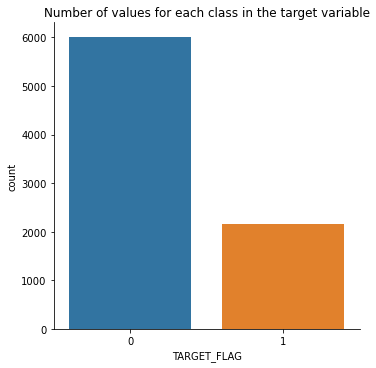

In [12]:
sns.factorplot('TARGET_FLAG',data=df_train_converted,kind='count')
plt.title('Number of values for each class in the target variable')

We see that there may be a slight imbalance in the dataset - the number of 0s are more so than the number of 1s which can affect the training. We can handle this by the following methods:
- Oversampling techniques
- Using models with penalisation
- Synthetic data

In [13]:
print('{}% of total target values are classified as 0'.format((df_train_converted[df_train_converted['TARGET_FLAG']==0].shape[0]/df_train_converted.shape[0])*100))
print('{}% of total target values are classified as 1'.format((df_train_converted[df_train_converted['TARGET_FLAG']==1].shape[0]/df_train_converted.shape[0])*100))

73.61842911407915% of total target values are classified as 0
26.38157088592084% of total target values are classified as 1


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Kids(Teenagers) driving the car')

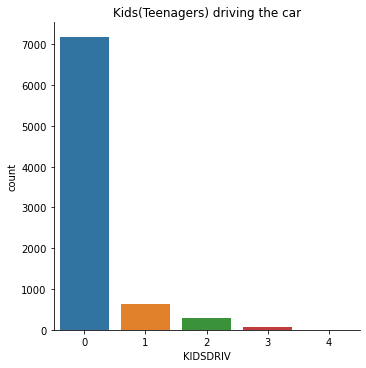

In [14]:
sns.factorplot('KIDSDRIV',data=df_train_converted,kind='count')
plt.title('Kids(Teenagers) driving the car')

It is perhaps more likely for a car to get into a crash when there are teenagers driving it. However, since the data is skewed towards individuals who have 0 kids who drive the cars, it may be interesting to see if there is indeed a proven correlation between the variable and the target - given that the target is mostly 0.

Text(0.5, 1.0, 'Age of people driving the car')

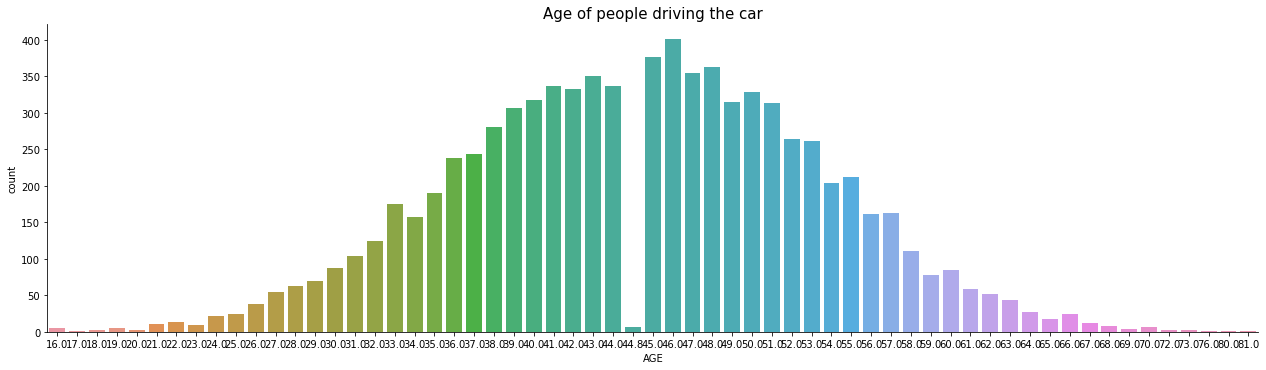

In [15]:
sns.factorplot('AGE',data=df_train_converted,kind='count',aspect=3.5)
plt.title('Age of people driving the car',fontsize=15)

Most of the individuals driving the car seem to be in the range of 40 to 53. Which makes sense - since most of the data has a target value 0, we can perhaps go with the intuition that people in this age group are rather safe and less likely to claim for insurance(as they are less likely to be in an accident)

Text(0.5, 1.0, 'Kids at home')

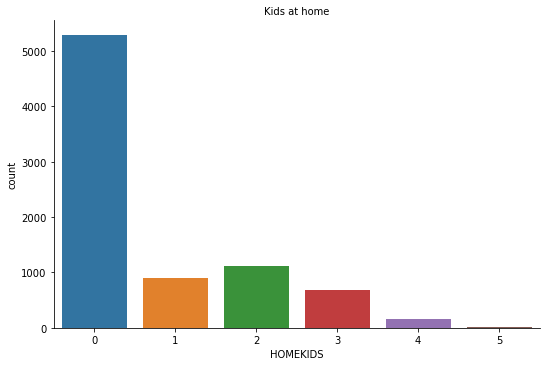

In [16]:
sns.factorplot('HOMEKIDS',data=df_train_converted,kind='count',aspect=1.5)
plt.title('Kids at home',fontsize=10)

Text(0.5, 1.0, 'Years of Joining')

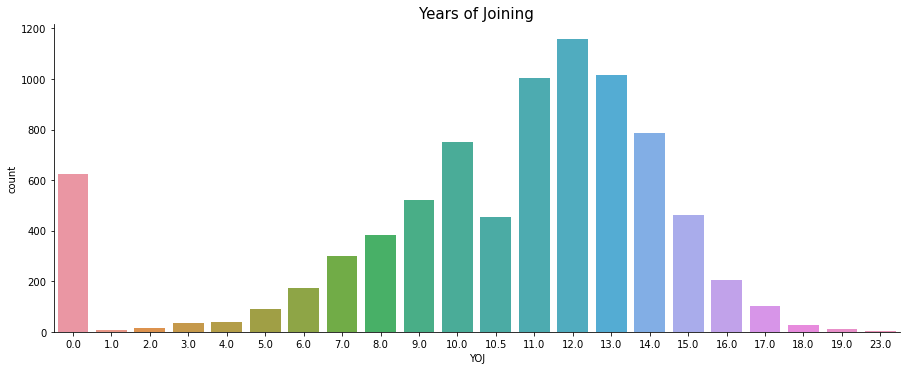

In [17]:
sns.factorplot('YOJ',data=df_train_converted,kind='count',aspect=2.5)
plt.title('Years of Joining',fontsize=15)

In the two plots below, we make an assumption that perhaps those who are living with their family(are married and have kids etc) might be more careful than those who are not, and there might be a relationship between these variable and the target.

Text(0.5, 1.0, 'Parent or not')

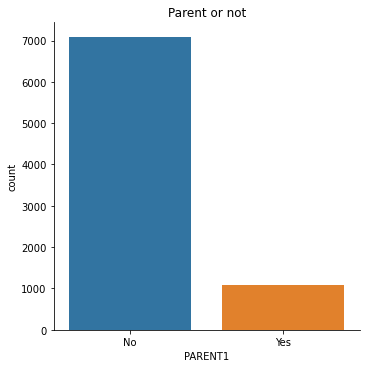

In [18]:
sns.factorplot('PARENT1',data=df_train_converted,kind='count')
plt.title('Parent or not')

Text(0.5, 1.0, 'Marital Status')

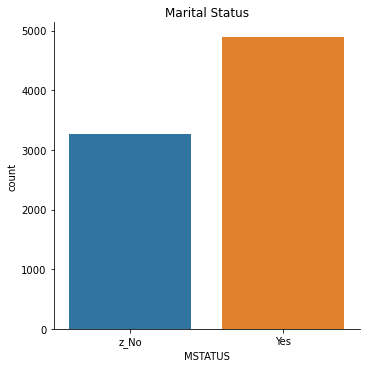

In [19]:
sns.factorplot('MSTATUS',data=df_train_converted,kind='count')
plt.title('Marital Status')

A distribution of the (two) genders in the dataset

Text(0.5, 1.0, 'Gender')

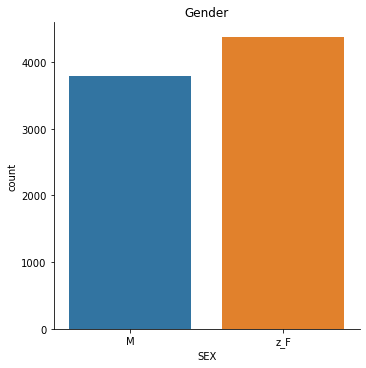

In [20]:
sns.factorplot('SEX',data=df_train_converted,kind='count')
plt.title('Gender')

Distribution of Education levels.

Text(0.5, 1.0, 'Education Level')

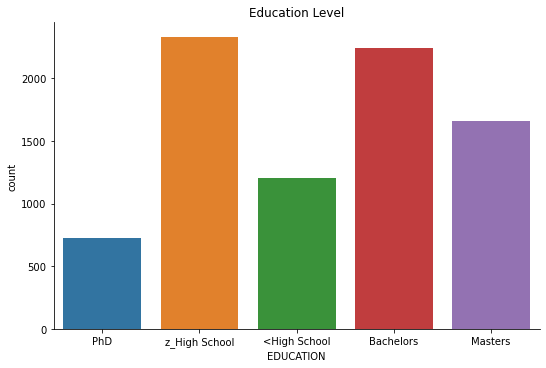

In [21]:
sns.factorplot('EDUCATION',data=df_train_converted,kind='count',aspect=1.5)
plt.title('Education Level')

Text(0.5, 1.0, 'Job')

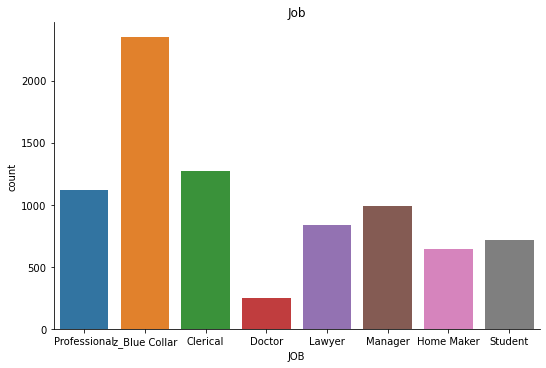

In [22]:
sns.factorplot('JOB',data=df_train_converted,kind='count',aspect=1.5)
plt.title('Job')

Text(0.5, 1.0, 'TIF')

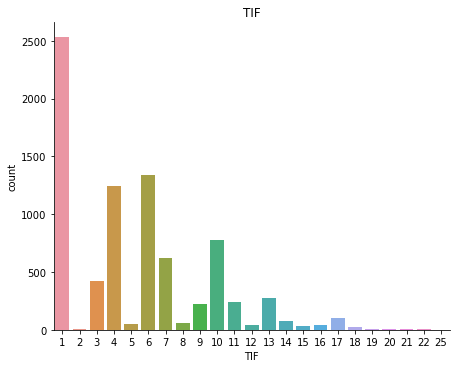

In [23]:
sns.factorplot('TIF',data=df_train_converted,kind='count',aspect=1.25)
plt.title('TIF')

Text(0.5, 1.0, 'Type of car')

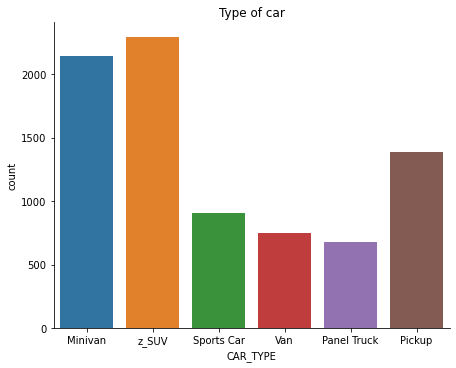

In [24]:
sns.factorplot('CAR_TYPE',data=df_train_converted,kind='count',aspect=1.25)
plt.title('Type of car')

A 'red car' is less likely to get into a crash by intution, as at night/bad weather/poor visibility conditions, it would be visible the most.

Text(0.5, 1.0, 'RED car')

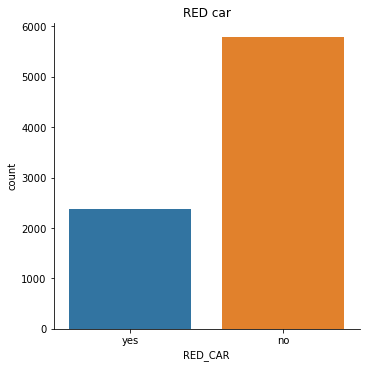

In [25]:
sns.factorplot('RED_CAR',data=df_train_converted,kind='count')
plt.title('RED car')

Number of times a claim has been filed might tell us if the individual files a claim again

Text(0.5, 1.0, 'Claim frequency')

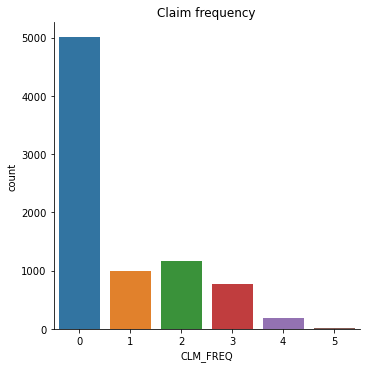

In [26]:
sns.factorplot('CLM_FREQ',data=df_train_converted,kind='count')
plt.title('Claim frequency')

If the license is revoked - perhaps it can tell us if the person is a reckless driver

Text(0.5, 1.0, 'License revoked')

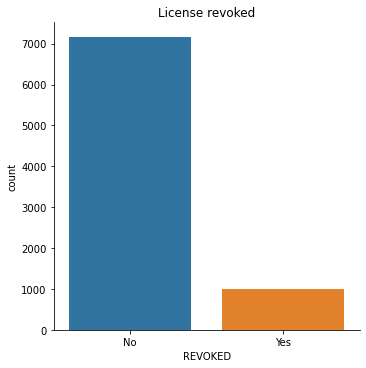

In [27]:
sns.factorplot('REVOKED',data=df_train_converted,kind='count')
plt.title('License revoked')

Text(0.5, 1.0, 'MVR points')

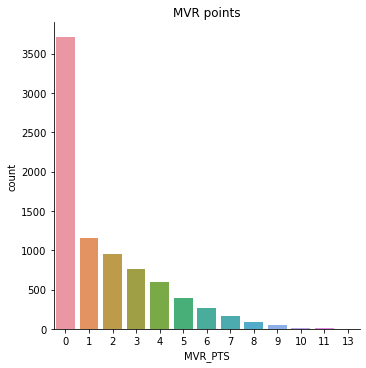

In [28]:
sns.factorplot('MVR_PTS',data=df_train_converted,kind='count')
plt.title('MVR points')

Text(0.5, 1.0, 'Age of the car')

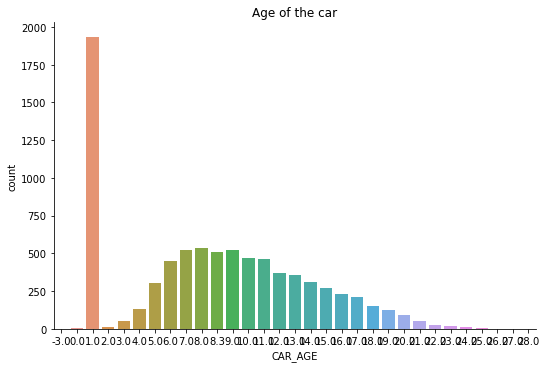

In [29]:
sns.factorplot('CAR_AGE',data=df_train_converted,kind='count',aspect=1.5)
plt.title('Age of the car')

Indeed, the age of a car cannot be less than 0. Hence the outlier needs to be removed.

In [30]:
df_train_converted = df_train_converted[df_train_converted['CAR_AGE']!=-3]

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'area')

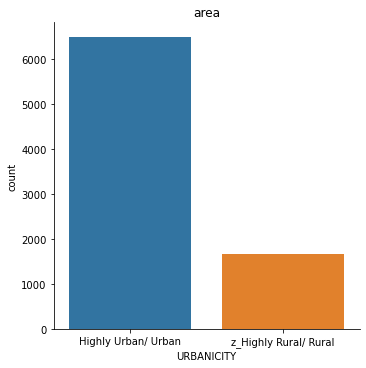

In [31]:
sns.factorplot('URBANICITY',data=df_train_converted,kind='count')
plt.title('area')

#### Univariate - Quantitative

count    8160.000000
mean       33.484191
std        15.908705
min         5.000000
25%        22.000000
50%        33.000000
75%        44.000000
max       142.000000
Name: TRAVTIME, dtype: float64


Text(0.5, 1.0, 'Travel time')

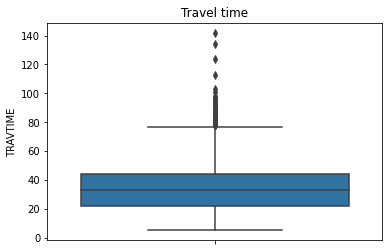

In [32]:
print(df_train_converted['TRAVTIME'].describe())
sns.boxplot(df_train_converted['TRAVTIME'],orient='v')
plt.title('Travel time')

It is entirely possible that the duration of traveling can determine whether a person is at risk or not. The average time seems to be about 30 minutes.

count      8160.000000
mean       1504.328977
std        4704.315177
min           0.000000
25%           0.000000
50%           0.000000
75%        1036.000000
max      107586.136160
Name: TARGET_AMT, dtype: float64


Text(0.5, 1.0, 'Amount costed for the accident')

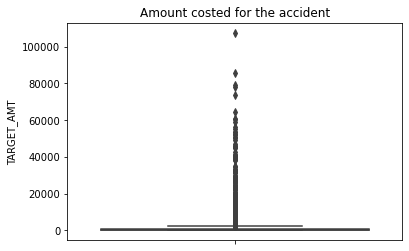

In [33]:
print(df_train_converted['TARGET_AMT'].describe())
sns.boxplot(df_train_converted['TARGET_AMT'],orient='v')
plt.title('Amount costed for the accident')

Since target amount has a direct relationship with the target flag, we will not be using this variable for our analysis. However it is interesting to note that the column has a huge spread(and high variance) thus making it quite volatile to predict.

count      8160.000000
mean      61899.712806
std       46259.930331
min           0.000000
25%       29705.750000
50%       57388.000000
75%       83307.000000
max      367030.000000
Name: INCOME_INT, dtype: float64


Text(0.5, 1.0, 'Income distribution')

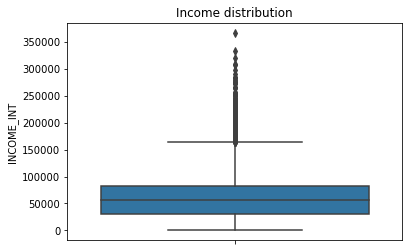

In [34]:
print(df_train_converted['INCOME_INT'].describe())
sns.boxplot(df_train_converted['INCOME_INT'],orient='v')
plt.title('Income distribution')

Since it is entirely possible for people to have a very wide range of incomes, it is important information to be included in the model and we will not be removing any 'outliers' or unusually high values in this case.

count     8160.000000
mean     15709.938725
std       8420.249293
min       1500.000000
25%       9280.000000
50%      14440.000000
75%      20850.000000
max      69740.000000
Name: BLUEBOOK_INT, dtype: float64


Text(0.5, 1.0, 'Bluebook distribution')

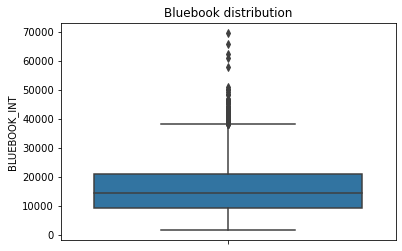

In [35]:
print(df_train_converted['BLUEBOOK_INT'].describe())
sns.boxplot(df_train_converted['BLUEBOOK_INT'],orient='v')
plt.title('Bluebook distribution')

The bluebook distribution also shows a few slightly 'high' values. They will not be outliers, as most likely they correspond to the high end cars in the dataset.

In [36]:
df_train_converted[df_train_converted['BLUEBOOK_INT']>50000]['CAR_TYPE'].unique()

array(['Panel Truck', 'Minivan'], dtype=object)

count     8160.000000
mean      4033.462990
std       8771.605028
min          0.000000
25%          0.000000
50%          0.000000
75%       4633.750000
max      57037.000000
Name: OLDCLAIM_INT, dtype: float64


Text(0.5, 1.0, 'Previous claims')

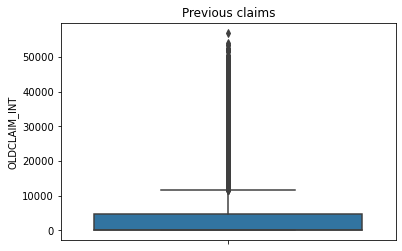

In [37]:
print(df_train_converted['OLDCLAIM_INT'].describe())
sns.boxplot(df_train_converted['OLDCLAIM_INT'],orient='v')
plt.title('Previous claims')

This column obviously, has a very varied range in its values. This can perhaps be attributed to the fact that the bluebook values in themselves are quite different for different cars and it also depends on the intensity of the accident.

In [38]:
df_train_converted[df_train_converted['OLDCLAIM_INT']>35000][['CAR_TYPE','BLUEBOOK_INT']].head()

,CAR_TYPE,BLUEBOOK_INT
INDEX,,
4,z_SUV,4010
36,z_SUV,14130
164,Pickup,11620
222,Sports Car,12930
235,Panel Truck,42550


### Multivariate - Feature Engineering

#### Correlation plot

Text(0.5, 1.0, "Pearson's correlation for the various quantitative factors")

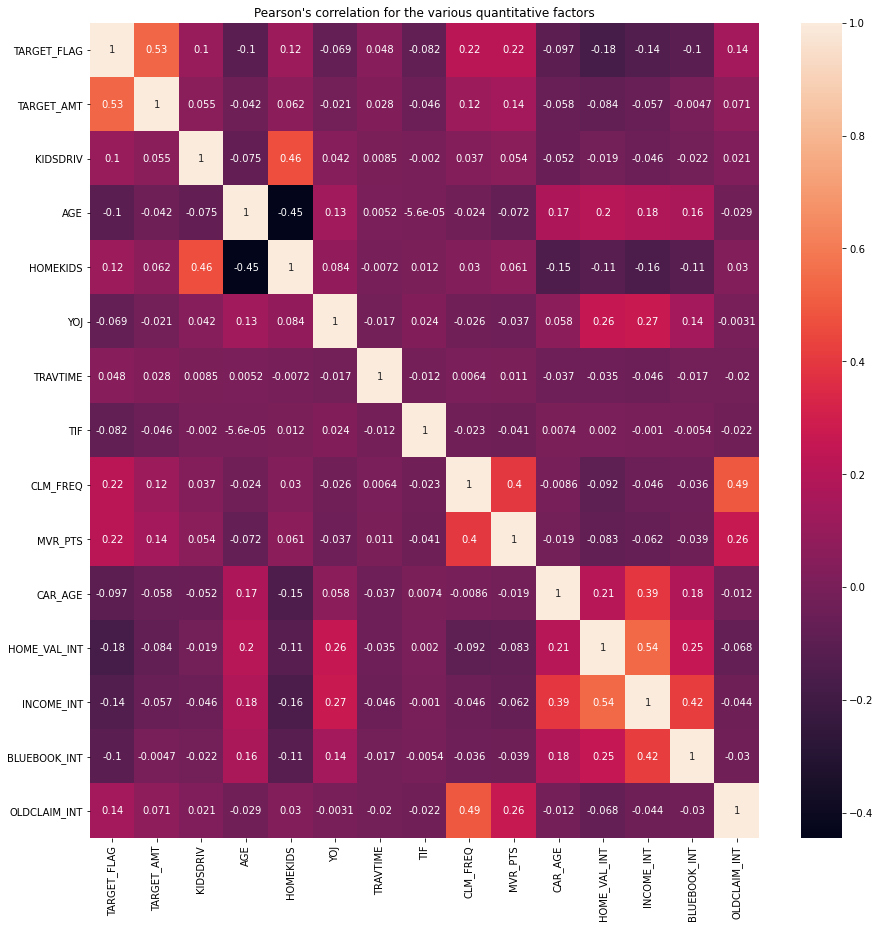

In [39]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_train_converted.corr(),annot=True,ax=ax)
plt.title("Pearson's correlation for the various quantitative factors")

According to the correlation plot, we can see that there are at best very weak correlations, not more than the value of 0.2. Therefore, the most correlated variables seem to be 
- Kids driving
- the Kids at home
- age 
- MVR_PTS 
- Claim frequency
- Home value
- Income 
- Bluebook 
- Old claims.



#### Qualitative 

As for the qualitative variables, we can use a popular statistic called 'Cramers V'. We see a relationship(Correlation) between 2 categorical variables. We pick the ones with the highest correlation values 

In [40]:
def cramers_corrected_stat(confusion_matrix):
    """ 
    Input: Contingency table
    Output: Cramers coefficient
    Description: calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#### Marital Status

In [41]:
cross_tab = pd.crosstab(df_train_converted['MSTATUS'], df_train_converted['TARGET_FLAG'])
print("The cramer's correlation for Marital Status with the target:",cramers_corrected_stat(cross_tab))

The cramer's correlation for Marital Status with the target: 0.13417808379878376


In [42]:
no_1 = df_train_converted.loc[(df_train_converted['MSTATUS']=='z_No')&(df_train_converted['TARGET_FLAG']==1)].shape[0]
yes_1 = df_train_converted.loc[(df_train_converted['MSTATUS']=='Yes')&(df_train_converted['TARGET_FLAG']==1)].shape[0]
no_0 = df_train_converted.loc[(df_train_converted['MSTATUS']=='z_No')&(df_train_converted['TARGET_FLAG']==0)].shape[0]
yes_0 = df_train_converted.loc[(df_train_converted['MSTATUS']=='Yes')&(df_train_converted['TARGET_FLAG']==0)].shape[0]

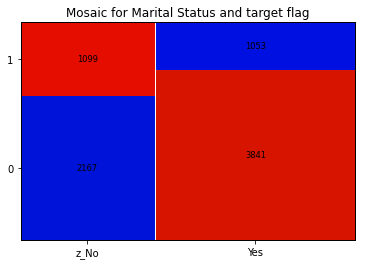

In [43]:
props={}
props[('z_No',1)]={'facecolor':'red', 'edgecolor':'white'}
props[('Yes',1)]={'facecolor':'red', 'edgecolor':'white'}
props[('z_No',0)]={'facecolor':'aqua','edgecolor':'white'}
props[('Yes',0)]={'facecolor':'aqua','edgecolor':'white'}
labelizer=lambda k:{('z_No','1'):no_1,('z_No','0'): no_0,('Yes','1'):yes_1,('Yes','0'):yes_0}[k]
fig,ax = plt.subplots(1,1)
mosaic(df_train_converted,['MSTATUS','TARGET_FLAG'],labelizer=labelizer,properties=props,statistic=True,ax=ax)
plt.title('Mosaic for Marital Status and target flag')
plt.show()

The mosaic plots tell us that those who are married are lesser in number to those who are not married, for filing claims. This goes with the earlier intuition that those who live with family might be more careful while driving.

#### Education

In [44]:
cross_tab = pd.crosstab(df_train_converted['EDUCATION'], df_train_converted['TARGET_FLAG'])
print("The cramer's correlation for Education with the target:",cramers_corrected_stat(cross_tab))

The cramer's correlation for Education with the target: 0.14286830610900125


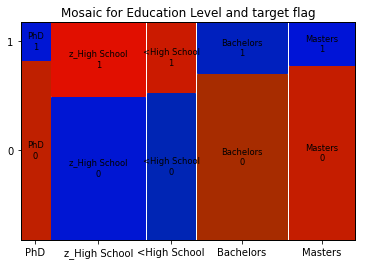

In [45]:
fig,ax = plt.subplots(1,1)
mosaic(df_train_converted,['EDUCATION','TARGET_FLAG'],statistic=True,ax=ax)
plt.title('Mosaic for Education Level and target flag')
plt.show()

We see that those who have upto high school education contribute have a higher claim to no claim ratio as opposed to those who have studied further than that.

#### Car Use

In [46]:
cross_tab = pd.crosstab(df_train_converted['CAR_USE'], df_train_converted['TARGET_FLAG'])
print("The cramer's correlation for Car Use with the target:",cramers_corrected_stat(cross_tab))

The cramer's correlation for Car Use with the target: 0.14215095681204054


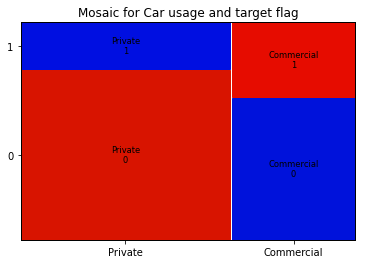

In [47]:
fig,ax = plt.subplots(1,1)
mosaic(df_train_converted,['CAR_USE','TARGET_FLAG'],statistic=True,ax=ax)
plt.title('Mosaic for Car usage and target flag')
plt.show()

Intuitively, a person using the car privately would be more careful than the cars driven for 'commercial' reasons.

#### Red Car

In [48]:
cross_tab = pd.crosstab(df_train_converted['RED_CAR'], df_train_converted['TARGET_FLAG'])
print("The cramer's correlation for Red Car with the target:",cramers_corrected_stat(cross_tab))

The cramer's correlation for Red Car with the target: 0.0


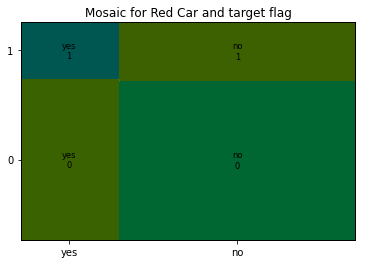

In [49]:
fig,ax = plt.subplots(1,1)
mosaic(df_train_converted,['RED_CAR','TARGET_FLAG'],statistic=True,ax=ax)
plt.title('Mosaic for Red Car and target flag')
plt.show()

Unfortunately there is no correlation between the colour of the car(especially red) and the target.

#### Job

In [50]:
cross_tab = pd.crosstab(df_train_converted['JOB'], df_train_converted['TARGET_FLAG'])
print("The cramer's correlation for Job type with the target:",cramers_corrected_stat(cross_tab))

The cramer's correlation for Job type with the target: 0.1707421820537856


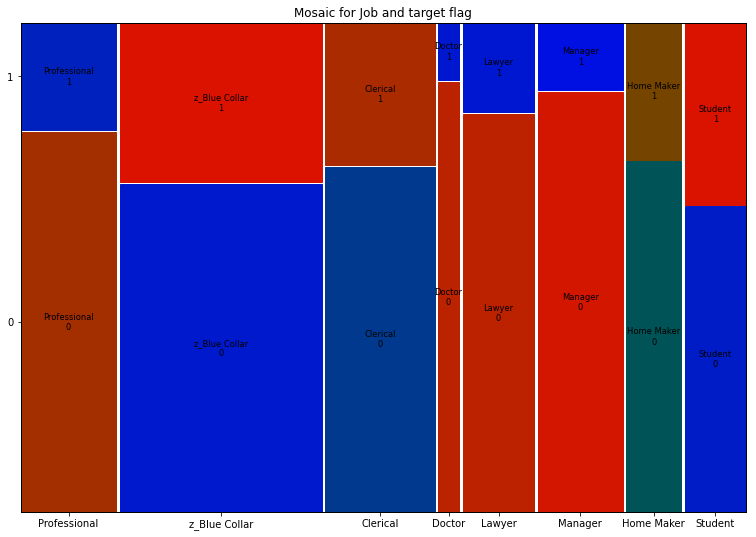

In [51]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(13, 9)
mosaic(df_train_converted,['JOB','TARGET_FLAG'],statistic=True,ax=ax)

plt.title('Mosaic for Job and target flag')
plt.show()

There seems to be a correlation between the kind of job vs accidents(or insurance claims). Students seem to be the ones who have the highest ratio for claim to no claim.

#### Urban City or not

In [52]:
cross_tab = pd.crosstab(df_train_converted['URBANICITY'], df_train_converted['TARGET_FLAG'])
print("The cramer's correlation for type of city(Urban/Rural) with the target:",cramers_corrected_stat(cross_tab))

The cramer's correlation for type of city(Urban/Rural) with the target: 0.22358403768667634


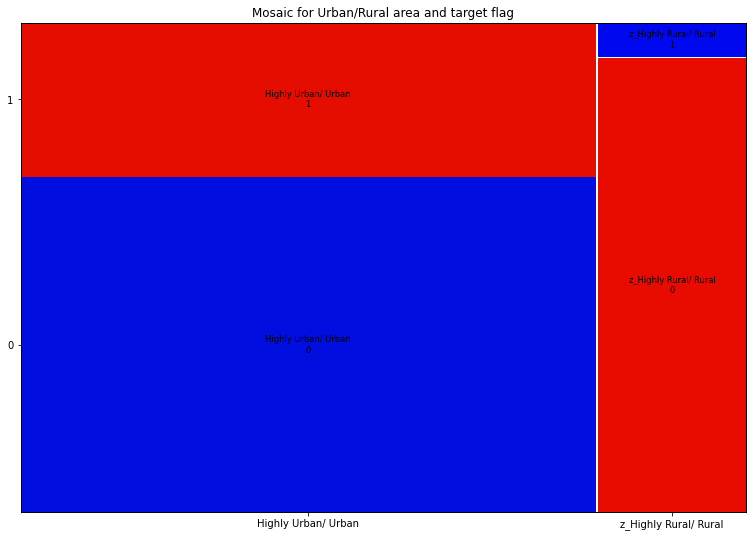

In [53]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(13, 9)
mosaic(df_train_converted,['URBANICITY','TARGET_FLAG'],statistic=True,ax=ax)

plt.title('Mosaic for Urban/Rural area and target flag')
plt.show()

The highest correlation seems to be for the kind of area an individual is living in. This makes sense - as those living in more populated areas (highly urban) are more likely to get into an accident(and file an insurance claim)

#### Car type

In [54]:
cross_tab = pd.crosstab(df_train_converted['CAR_TYPE'], df_train_converted['TARGET_FLAG'])
print("The cramer's correlation for Car Type with the target:",cramers_corrected_stat(cross_tab))

The cramer's correlation for Car Type with the target: 0.14221661136904512


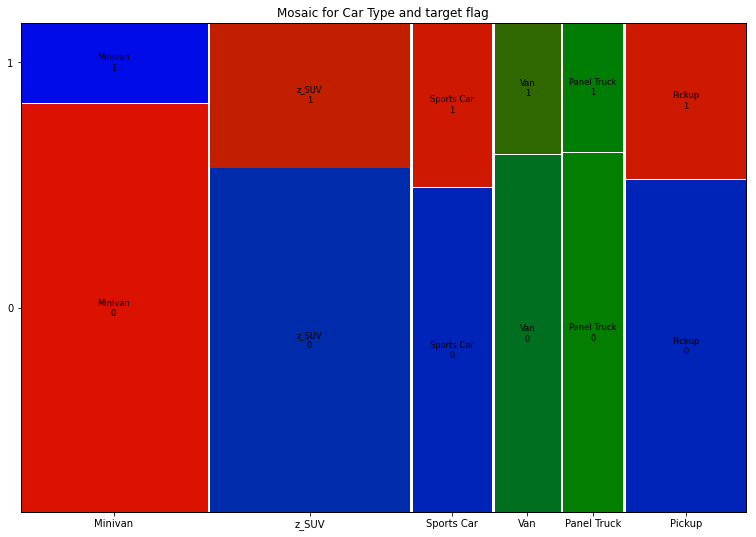

In [55]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(13, 9)
mosaic(df_train_converted,['CAR_TYPE','TARGET_FLAG'],statistic=True,ax=ax)

plt.title('Mosaic for Car Type and target flag')
plt.show()

The people who purchase minivans usually do it for their family. So naturally, those are the ones who drive the most carefully of the lot.

#### License Revoked

In [56]:
cross_tab = pd.crosstab(df_train_converted['REVOKED'], df_train_converted['TARGET_FLAG'])
print("The cramer's correlation for License Revoked with the target:",cramers_corrected_stat(cross_tab))

The cramer's correlation for License Revoked with the target: 0.15066240809636852


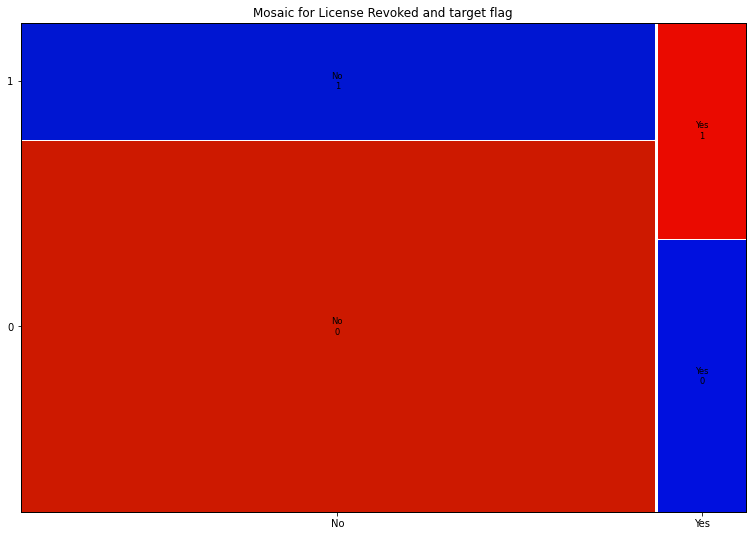

In [57]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(13, 9)
mosaic(df_train_converted,['REVOKED','TARGET_FLAG'],statistic=True,ax=ax)

plt.title('Mosaic for License Revoked and target flag')
plt.show()

Again, a clear correlation - those whose license was revoked are more likely to have filed for insurance (and gotten into accidents) claims than those whose license has not been revoked.

#### Sex

In [58]:
cross_tab = pd.crosstab(df_train_converted['SEX'], df_train_converted['TARGET_FLAG'])
print("The cramer's correlation for Sex with the target:",cramers_corrected_stat(cross_tab))

The cramer's correlation for Sex with the target: 0.017389903777331888


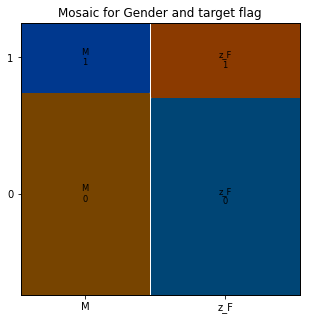

In [59]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(5, 5)
mosaic(df_train_converted,['SEX','TARGET_FLAG'],statistic=True,ax=ax)

plt.title('Mosaic for Gender and target flag')
plt.show()

Gender seems to be almost uncorrelated to the insurance claim target flag.

#### Parent

In [60]:
cross_tab = pd.crosstab(df_train_converted['PARENT1'], df_train_converted['TARGET_FLAG'])
print("The cramer's correlation for Parenthood with the target:",cramers_corrected_stat(cross_tab))

The cramer's correlation for Parenthood with the target: 0.15693925321013377


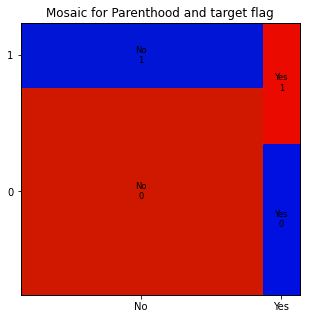

In [61]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(5, 5)
mosaic(df_train_converted,['PARENT1','TARGET_FLAG'],statistic=True,ax=ax)

plt.title('Mosaic for Parenthood and target flag')
plt.show()

Again, we have only very weak correlations between the categorical variables and the target. Thus, we pick the most correlated ones from the lot:
- Urban city or not
- Education
- License Revoked
- Job
- Car Use
- Marital Status
- Parent hood
- Car Type.

All of these are picked as their correlation lies somewhere between 0.13 and 0.25. This is, a very weak correlation indeed, however it is the best we have - therefore we proceed with these features.

### Preprocessing before modelling

In [62]:
selected_columns = ['KIDSDRIV','HOMEKIDS','AGE','MVR_PTS','CLM_FREQ',
                    'HOME_VAL_INT','INCOME_INT','BLUEBOOK_INT','OLDCLAIM_INT',
                    'URBANICITY','EDUCATION','REVOKED','JOB','CAR_USE','MSTATUS',
                    'PARENT1','CAR_TYPE','TARGET_FLAG']
categorical_columns = ['URBANICITY','EDUCATION','REVOKED','JOB','CAR_USE','MSTATUS','PARENT1','CAR_TYPE']
numerical_columns = ['KIDSDRIV','HOMEKIDS','AGE','MVR_PTS','CLM_FREQ','HOME_VAL_INT','INCOME_INT','BLUEBOOK_INT','OLDCLAIM_INT']

In [63]:
def ohe(df,columns):
    '''
    input: Dataframe and columns to be one hot encoded
    Output: Resulting dataframe
    Description: Performs One hot encoding on the columns mentioned in the columns list
    '''
    for column in columns:
        df=df.join(pd.get_dummies(df[column], prefix=column)).drop(column,axis=1)
    return df

In [64]:
#Scaling is not really needed for tree based models. It is done mostly for the KNN model and any potential linear models
def scale_data(df, column_list):
    '''
    Input: Dataframe to be scaled, column list
    Output: Scaled data
    Description: Takes in a dataframe and a list of column names to transform
     returns a dataframe of scaled values'''
    df_to_scale = df[column_list]
    x = df_to_scale.values
    standard_scaler = StandardScaler()
    x_scaled = standard_scaler.fit_transform(x)
    df_to_scale = pd.DataFrame(x_scaled, columns=df_to_scale.columns)
    return df_to_scale

In [65]:
def preprocess(df,ohe_columns,target,selected_columns,scaling_columns):
    '''
    Input: Original dataset, columns to be one hot encoded, feature columns, columns to be scaled
    Output: Preprocessed dataframe
    Description: Performs one hot encoding and scaling for categorical and numerical data respectively
    '''
    df = df[selected_columns]
    df_preprocessed = ohe(df,ohe_columns)
    target_column = df_preprocessed[target]
    df_preprocessed.drop(columns=[target],inplace=True)
    columns = df_preprocessed.columns.tolist()
    for i in range(len(columns)):
        columns[i] = columns[i].replace('<','').replace(',','')    
    df_preprocessed.columns = columns
    df_to_scale = scale_data(df_preprocessed,scaling_columns)
    df_preprocessed = df_preprocessed.reset_index(drop=True)
    df_preprocessed[df_to_scale.columns.tolist()] = df_to_scale[df_to_scale.columns.tolist()]
    
    return df_preprocessed,target_column

In [66]:
df_preprocessed,target_column = preprocess(df_train_converted,categorical_columns,'TARGET_FLAG',selected_columns,numerical_columns)

In [67]:
def train_test_split_data(df,target,split=0.2):
    seed=7
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=split, random_state=seed)
    columns = X_train.columns.tolist()
    for i in range(len(columns)):
        columns[i] = columns[i].replace('<','').replace(',','')
    
    X_train.columns = columns
    X_test.columns = columns
    
    return X_train,X_test,y_train,y_test

In [68]:
X_train,X_test,y_train,y_test = train_test_split_data(df_preprocessed,target_column)

# Model Implementation

### Metrics

The metrics taken into account will be:
- f1 score: Harmonic mean between precision and recall. This gives us a good idea of the true positives and true negatives detected.
- accuracy: While this is one of the measures we take into account, it is important to note that in an unbalanced target class, accuracy in itself is not quite reliable.
- Precision: This gives us a measure of the true positives to the total positives detected.
- Recall: This gives us a measure of the true positives of the actual number of positive cases.
- Confusion Matrix: This will help us see the misclassifications and judge the best model based on that
- ROC AUC curve: Visual representation of true vs false positives detecting abilities of the models

In [69]:
def compute_metrics(y_pred,y_test):
    '''
    input: predicted output and the actual output
    output: Metrics - accuracy, f1, precision, recall, confusion matrix
    Description: Calculates the metrics for the inputs and returns the same
    '''
    accuracy = accuracy_score(y_pred,y_test)
    f1 = f1_score(y_pred,y_test)
    recall = recall_score(y_pred,y_test)
    precision = precision_score(y_pred,y_test)
    cm = confusion_matrix(y_pred,y_test,labels=[0,1])
    print('The accuracy is: {}'.format(accuracy))
    print('The f1 score is: {}'.format(f1))
    print('The recall is: {}'.format(recall))
    print('The precision is: {}'.format(precision))
    print('The confusion matrix is:  \n{}'.format(cm))
    
    return (accuracy,f1,recall,precision,cm)

#### Generalised prediction function

In [70]:
def prediction(model,X_test):
    '''
    input: Trained model
    output: Predicted values
    Description: Function to perform predictions on any model
    '''
    y_pred = model.predict(X_test)
    return y_pred

### Logistic Classifier (baseline)

In [71]:
def logistic_classifier(X_train,y_train):
    '''
    input: Training data (X and target y)
    output: regression model
    Description: Baseline classifer for binary classification problem: Logistic Regression
    '''
    logreg = LogisticRegression()
    logreg.fit(X_train,y_train)
    return logreg

In [72]:
logreg = logistic_classifier(X_train,y_train)
y_pred_lg =prediction(logreg,X_test)

In [73]:
log_analysis = compute_metrics(y_pred_lg,y_test)

The accuracy is: 0.7732843137254902
The f1 score is: 0.4714285714285714
The recall is: 0.625
The precision is: 0.37844036697247707
The confusion matrix is:  
[[1097  271]
 [  99  165]]


### XGBoost

In [74]:
def xgboost_classification(X_train,y_train):
    '''
    input: Preprocessed dataframe
    output: xgboost model trained on the preprocessed data
    Description: Training of an xgboost model
    '''
    
    model = xgb.XGBClassifier()
    model.fit(X_train,y_train)
    plot_importance(model,max_num_features=20)
    plt.figure(figsize=(20,20))
    return model

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:38:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy is: 0.7714460784313726
The f1 score is: 0.5236270753512134
The recall is: 0.590778097982709
The precision is: 0.4701834862385321
The confusion matrix is:  
[[1054  231]
 [ 142  205]]


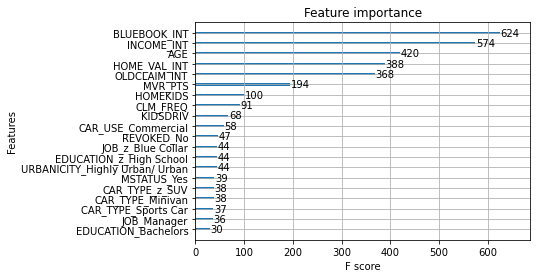

<Figure size 1440x1440 with 0 Axes>

In [75]:
model = xgboost_classification(X_train,y_train)
y_pred = prediction(model,X_test)
xgb_analysis = compute_metrics(y_pred,y_test)

The most important features turn out to be the bluebook values, income, age, home values and old claim values for the XGBoost model.

### LightGBM

In [76]:
def lightgbm_classification(X_train,y_train):
    '''
    input: Training data
    Output: LightGBM trained model
    Description: Binary classification using lightGBM
    '''    
    model = lgb.LGBMClassifier()
    model.fit(X_train,y_train)
    lgb.plot_importance(model,max_num_features=20)
    plt.figure(figsize=(20,20))    
    return model

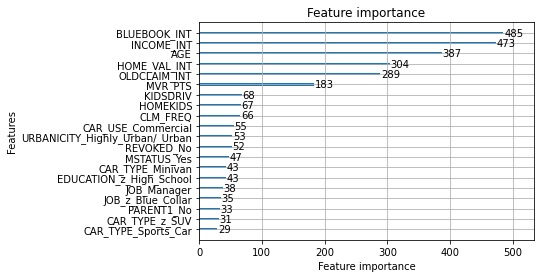

<Figure size 1440x1440 with 0 Axes>

In [77]:
model_lgb = lightgbm_classification(X_train,y_train)
y_pred_lgbm = prediction(model_lgb,X_test)

LightGBM has similar important features to the XGB, with a slight variation. The number of kids driving the car seems to be of more importance in this case.

In [78]:
lightgbm_analysis = compute_metrics(y_pred_lgbm,y_test)

The accuracy is: 0.7879901960784313
The f1 score is: 0.5471204188481676
The recall is: 0.6371951219512195
The precision is: 0.4793577981651376
The confusion matrix is:  
[[1077  227]
 [ 119  209]]


In [79]:
def lightgbm_classifier_cv(X_train,y_train,X_test):
    '''
    Input: Training data
    Output: Predicted values
    Description: Performing lightgbm with 5-fold cross validation, while trying to find the optimum number of boosting rounds
    '''
    params = {}
    params['max_bin'] = 10
    params['learning_rate'] = 0.2 
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'   
    params['sub_feature'] = 0.50     
    params['bagging_fraction'] = 0.85
    params['bagging_freq'] = 40
    params['num_leaves'] = 512
    params['min_data'] = 500
    params['verbose'] = -1
    dtrain_lgb = lgb.Dataset(X_train.values, label=y_train)

    
    cv_results = lgb.cv(params, dtrain_lgb, num_boost_round=500, nfold=5, 
                     early_stopping_rounds=40)
    num_boost_rounds_lgb = len(cv_results['binary_logloss-mean'])
    print('num_boost_rounds_lgb=' + str(num_boost_rounds_lgb))

    model_lgb = lgb.train(params, dtrain_lgb, num_boost_round=num_boost_rounds_lgb)
    y_pred_lgbm_cv = model_lgb.predict(X_test)
    y_pred_lgbm_cv=y_pred_lgbm_cv.round(0)
    y_pred_lgbm_cv=y_pred_lgbm_cv.astype(int)
    
    return y_pred_lgbm_cv

In [80]:
y_pred_lgbm_cv = lightgbm_classifier_cv(X_train,y_train,X_test)

num_boost_rounds_lgb=84


### KNN Classifier

In [81]:
def knn_classifier(X_train,y_train,k=7):
    '''
    input: Training data input and number of neighbours
    output: trained model
    Description: training knn classifier on the given data
    '''
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)

    return model

In [82]:
model_knn = knn_classifier(X_train,y_train)
y_pred_knn = prediction(model_knn,X_test)
knn_analysis = compute_metrics(y_pred_knn,y_test)

The accuracy is: 0.7561274509803921
The f1 score is: 0.4441340782122905
The recall is: 0.5678571428571428
The precision is: 0.3646788990825688
The confusion matrix is:  
[[1075  277]
 [ 121  159]]


## Analysis

### ROC-AUC

The code below is to plot the ROC-AUC values. The ROC-AUC gives us an idea of the kind of the ratio of false positives vs the false negatives. The closer the AUC score is to 1, the better it is at predicting the classes

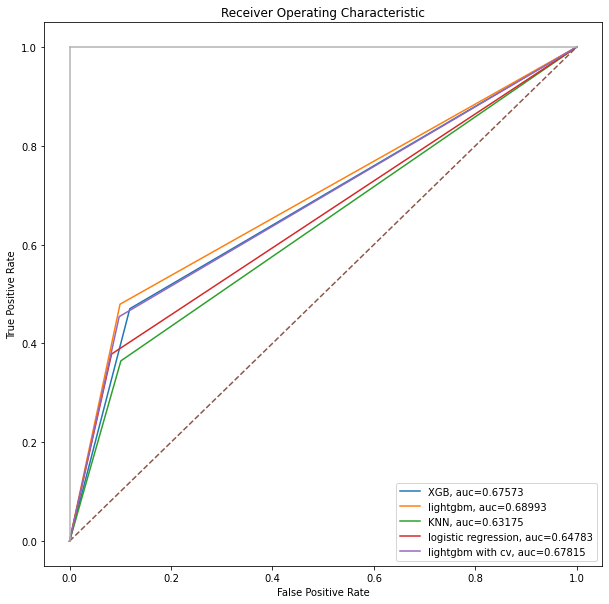

In [83]:
plt.figure(figsize=(10,10))
fpr, tpr, thresh = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred),5)
plt.plot(fpr,tpr,label="XGB, auc="+str(auc))


fpr, tpr, thresh = roc_curve(y_test, y_pred_lgbm)
auc = round(roc_auc_score(y_test, y_pred_lgbm),5)
plt.plot(fpr,tpr,label="lightgbm, auc="+str(auc))

fpr, tpr, thresh = roc_curve(y_test, y_pred_knn)
auc = round(roc_auc_score(y_test, y_pred_knn),5)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

fpr, tpr, thresh = roc_curve(y_test, y_pred_lg)
auc = round(roc_auc_score(y_test, y_pred_lg),5)
plt.plot(fpr,tpr,label="logistic regression, auc="+str(auc))

fpr, tpr, thresh = roc_curve(y_test, y_pred_lgbm_cv)
auc = round(roc_auc_score(y_test, y_pred_lgbm_cv),5)
plt.plot(fpr,tpr,label="lightgbm with cv, auc="+str(auc))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc=0)


The above ROC-AUC scores show that the decision tree based models beat the baseline logistic regression model. 
LightGBM and XGBoost have a comparable performance, in the sense that we see a nearly same value of auc for both these models. Since they are between 0.5 and 1, we can say that they are able to distinguish between the positives and negatives of the class. In addition, since their auc beats that of the baseline model, it would be a favourable choice for our application.

It is important to perform cross validation to see the actual performance - there is always a chance that the model works well on a subset of data only. Cross validation thus proves to be a good way to create a robust model.

However, with further hyperparameter tuning, we would be able to see a better performance with these models.

### Confusion Matrix

#### LightGBM

True positives: 209
False positives: 227
True negatives: 1077
False negatives: 119


Text(0.5, 1.0, 'Heat map for LightGBM Confusion matrix')

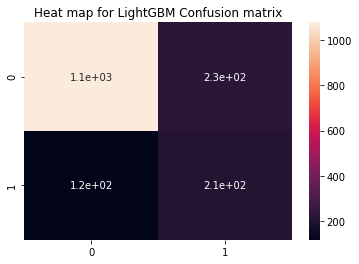

In [84]:
tn, fp, fn, tp = lightgbm_analysis[4].ravel()
print('True positives:',tp)
print('False positives:',fp)
print('True negatives:',tn)
print('False negatives:',fn)
sns.heatmap(lightgbm_analysis[4],annot=True)
plt.title('Heat map for LightGBM Confusion matrix')

The number of false negatives is low compared to the true positives. It is highly desirable to avoid a type 1 error, and for that reason, lightGBM is the prefered model out of the 4. 

False Positive rate for lightGBM is a bit high, however, the true negative value is indeed much higher.

Perhaps, if the dataset is more 'balanced', we would be able to achieve better results and lesser misclassifications.

#### XGBoost

True positives: 205
False positives: 231
True negatives: 1054
False negatives: 142


Text(0.5, 1.0, 'Heat map for XGBoost Confusion matrix')

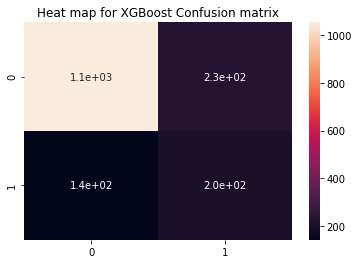

In [85]:
tn, fp, fn, tp = xgb_analysis[4].ravel()
print('True positives:',tp)
print('False positives:',fp)
print('True negatives:',tn)
print('False negatives:',fn)
sns.heatmap(xgb_analysis[4],annot=True)
plt.title('Heat map for XGBoost Confusion matrix')

We do note the comparable performance between the two decision tree models over here, however noting the slight difference in the false negative scenario: It is higher for xgb than for the lightgbm model. 

As for the false/true positives, both the models are nearly the same.

#### KNN

True positives: 159
False positives: 277
True negatives: 1075
False negatives: 121


Text(0.5, 1.0, 'Heat map for KNN Confusion matrix')

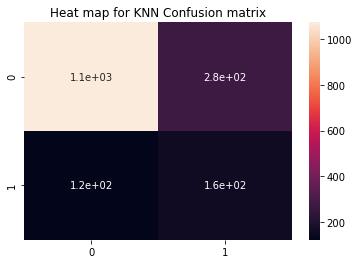

In [86]:
tn, fp, fn, tp = knn_analysis[4].ravel()
print('True positives:',tp)
print('False positives:',fp)
print('True negatives:',tn)
print('False negatives:',fn)
sns.heatmap(knn_analysis[4],annot=True)
plt.title('Heat map for KNN Confusion matrix')

What is interesting in the case of KNN is that it has lower type 1 errors (false negatives) than XGBoost, however, due to the fact that its true positives are much lesser than its false positives, it loses on the auc score. This means that this model, too, has potential, perhaps with better feature engineering.

# CSV file

## Preprocess

In [87]:
df_test_auto['HOME_VAL_INT'] = df_test_auto.apply(lambda x: convert_to_int(x['HOME_VAL']),axis=1)
df_test_auto['INCOME_INT'] = df_test_auto.apply(lambda x: convert_to_int(x['INCOME']),axis=1)
df_test_auto['BLUEBOOK_INT'] = df_test_auto.apply(lambda x: convert_to_int(x['BLUEBOOK']),axis=1)
df_test_auto['OLDCLAIM_INT'] = df_test_auto.apply(lambda x: convert_to_int(x['OLDCLAIM']),axis=1)

In [88]:
df_test_converted = df_test_auto.drop(columns=['HOME_VAL','INCOME','BLUEBOOK','OLDCLAIM'])

In [89]:
df_test_converted.isna().sum()

TARGET_FLAG     2141
TARGET_AMT      2141
KIDSDRIV           0
AGE                1
HOMEKIDS           0
YOJ               94
PARENT1            0
MSTATUS            0
SEX                0
EDUCATION          0
JOB              139
TRAVTIME           0
CAR_USE            0
TIF                0
CAR_TYPE           0
RED_CAR            0
CLM_FREQ           0
REVOKED            0
MVR_PTS            0
CAR_AGE          129
URBANICITY         0
HOME_VAL_INT     111
INCOME_INT       125
BLUEBOOK_INT       0
OLDCLAIM_INT       0
dtype: int64

In [90]:
df_test_converted['YOJ'].fillna(round(df_test_converted['YOJ'].mean(),1),inplace=True)
df_test_converted['HOME_VAL_INT'].fillna(round(df_test_converted['HOME_VAL_INT'].mean(),1),inplace=True)
df_test_converted['JOB'].fillna(df_test_converted['JOB'].mode()[0],inplace=True)
df_test_converted['CAR_AGE'].fillna(round(df_test_converted['CAR_AGE'].mean(),1),inplace=True)
df_test_converted['INCOME_INT'].fillna(round(df_test_converted['INCOME_INT'].mean(),1),inplace=True)
df_test_converted['AGE'].fillna(round(df_test_converted['AGE'].mean(),1),inplace=True)

In [91]:
df_test_converted = df_test_converted.reset_index(drop=True)

In [92]:
df_test_data,test_target = preprocess(df_test_converted,categorical_columns,'TARGET_FLAG',selected_columns,numerical_columns)

## Prediction

In [93]:
target_column = target_column.reset_index(drop=True)

In [94]:
test_predictions = lightgbm_classifier_cv(df_preprocessed,target_column,df_test_data)

num_boost_rounds_lgb=78


In [95]:
df_test_predictions = pd.DataFrame({'TARGET_FLAG': test_predictions})

In [96]:
df_test_predictions.reset_index(inplace=True)

In [98]:
df_test_predictions['TARGET_FLAG'].unique()

array([0, 1])

In [99]:
df_test_predictions.to_csv('Submission_Descartes_Akhila_Vangara.csv')

# Conclusion & further work

While we have 3 models out of which 2 beat the baseline model, it would be interesting to work further to achieve better results. some steps include:
- Oversampling/Synthetic data for balancing the classes
- Further feature engineering to find more relevant features
- Deep Learning methods
- Hyperparameter tuning
- Check for feature correlations and use only non correlated features
